## Data Visualization

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/WayneZheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/WayneZheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/WayneZheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
AxesSubplot(0.125,0.125;0.775x0.755)


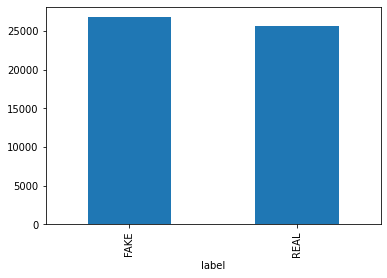

In [2]:
import numpy as np
import pandas as pd
import os 
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import string
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop = stopwords.words('english')
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

# def punctuation_removal(text):
#     all_list = [char for char in text if char not in string.punctuation]
#     clean_str = ''.join(all_list)
#     return clean_str



curr_path = os.getcwd()
curr_path = os.path.dirname(curr_path)
df1 = pd.read_csv(curr_path+"/combinedDataset1.csv")
df2 = pd.read_csv(curr_path+"/combinedDataset2.csv")

data = pd.concat([df1, df2])
# There is an unexpected third label value "fake", we need to convert this to "FAKE"
data.loc[(data.label=='fake'), 'label']='FAKE'
data = shuffle(data)
data = data.reset_index(drop=True)
# data['text'] = data['text'].apply(lambda x: x.lower())
# data['text'].apply(punctuation_removal)

# data['text']=data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# WARNING: THIS CLEANING STEP TOOK OVER 2 HOURS FOR 2.5 GHz Dual-Core Intel Core i5
data['text']=data['text'].apply(cleaning)
print(data.groupby(['label'])['text'].count().plot(kind="bar"))
plt.show()

In [5]:
# To avoid running the text cleaning step for over hours, we are storing the cleaned data for later use
# To get the data back when restarting the jupyter server use "%store -r cleaned_data_text"
cleaned_data_text = data['text']
%store cleaned_data_text

Stored 'cleaned_data_text' (Series)


In [6]:
print(cleaned_data_text)

0        miami reuters donald trump friday called disar...
1        washington reuters saudi arabia completed main...
2        could dick cheney engineer war go history crim...
3        lagos reuters britain considering request sell...
4        anyone wonder reverend al sharpton got started...
                               ...                        
52447    donald trump response horrific massacre orland...
52448    new mexico led state percent baby born birth c...
52449    house intelligence committee chairman rep devi...
52450    washington reuters head u environmental protec...
52451    two protagonist jesus campos alleged shooter s...
Name: text, Length: 52452, dtype: object


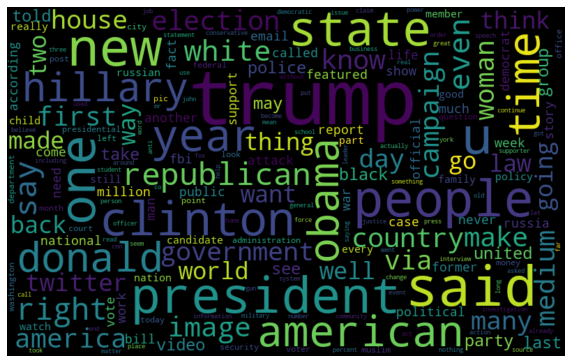

In [7]:
# Top words in the fake news data
from wordcloud import WordCloud

fake_data = data[data['label']=='FAKE']
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width=800, height=500, max_font_size=110,
                        collocations=False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

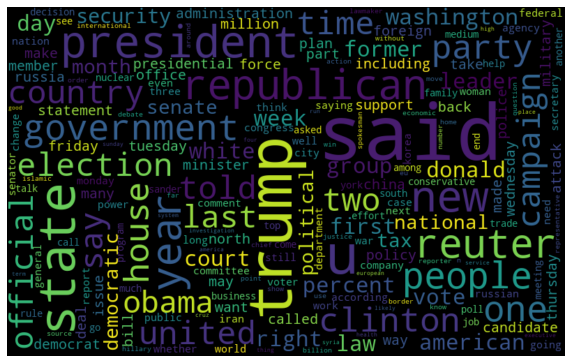

In [8]:
real_data = data[data['label']=='REAL']
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width=800, height=500, max_font_size=110,
                        collocations=False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

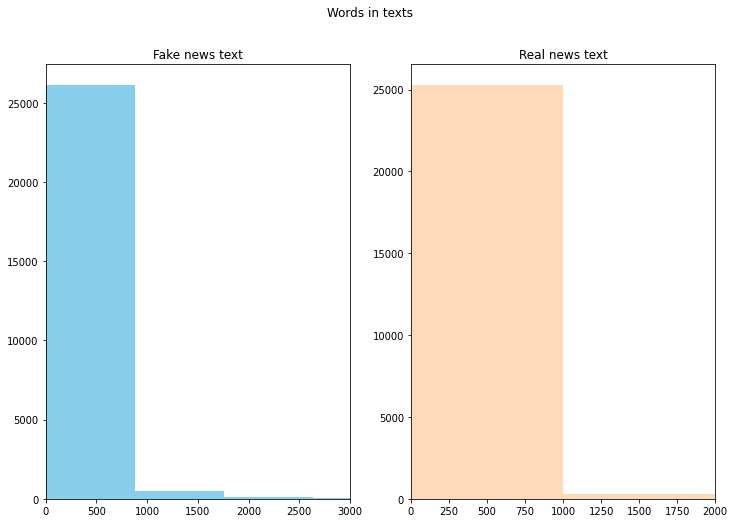

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']=='FAKE']['text'].str.split().map(lambda x: len(x))
ax1.set_xlim([0, 3000])
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['label']=='REAL']['text'].str.split().map(lambda x: len(x))
ax2.set_xlim([0, 2000])
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

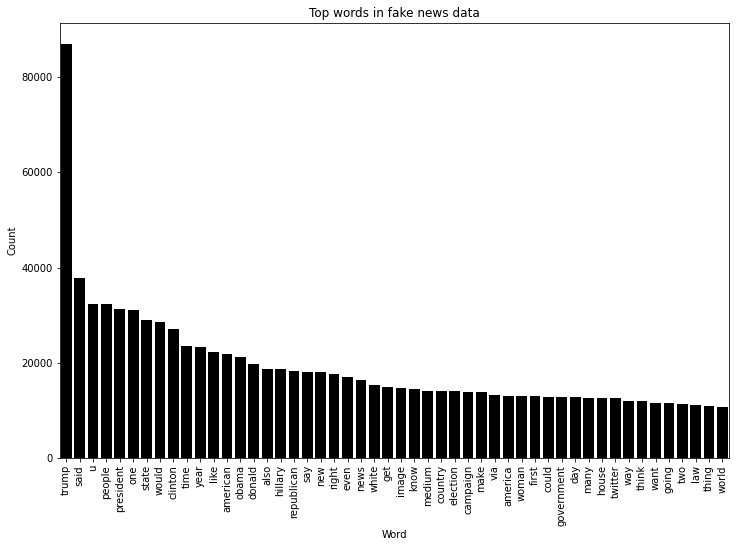

In [9]:
from nltk import tokenize
import seaborn as sns
token_space = tokenize.WhitespaceTokenizer()

def counter_fake(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), 
                                "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax=sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'black')
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 'vertical')
    plt.title("Top words in fake news data")
    plt.show()

counter_fake(data[data['label']=='FAKE'], 'text', 50)

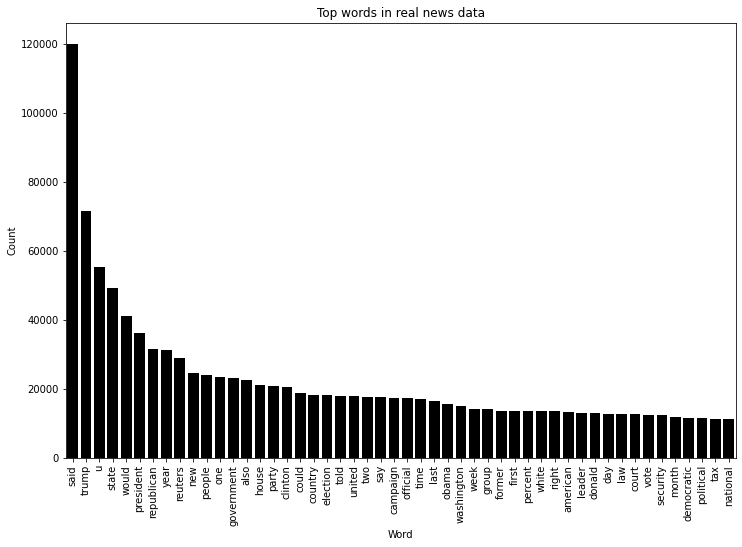

In [10]:
def counter_real(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), 
                                "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax=sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'black')
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 'vertical')
    plt.title("Top words in real news data")
    plt.show()

counter_real(data[data['label']=='REAL'], 'text', 50)

## Modeling

In [21]:
from sklearn import metrics
import itertools

def display_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('Ground-True label')
    plt.xlabel('Predicted label')

## Split the data into training and testing sets

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], 
                                                    test_size=0.2, random_state=41)



## Logistic Regression

Accuracy: 95.95%
Confusion matrix, without normalization


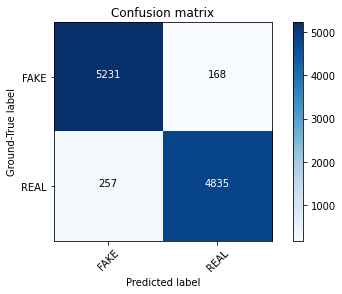

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Decision Tree Classifier

Accuracy: 95.33%
Confusion matrix, without normalization


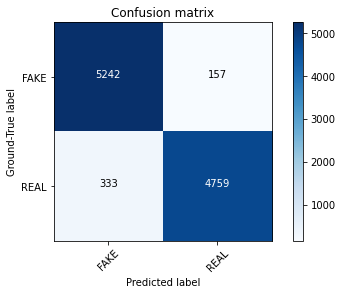

In [24]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion='entropy', 
                                                  max_depth= 20, 
                                                  splitter='best', 
                                                  random_state=41))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Random Forest Classifier

Accuracy: 94.95%
Confusion matrix, without normalization


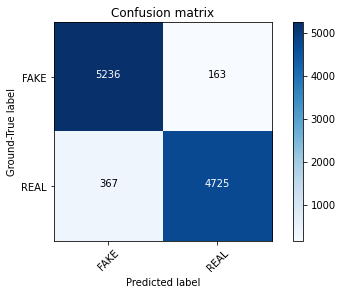

In [25]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50,
                                                  criterion='entropy'))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Passive Aggressive Classifier

Accuracy: 97.29%
Confusion matrix, without normalization


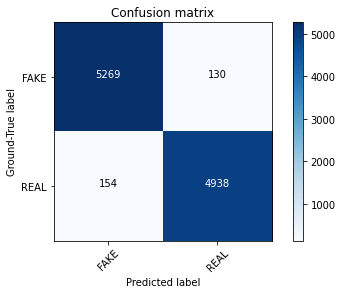

In [26]:
from sklearn.linear_model import PassiveAggressiveClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', PassiveAggressiveClassifier(max_iter=50))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## LSTM

In [43]:
import keras
from tensorflow.python.keras.optimizer_v2.adam import Adam
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

data.loc[(data.label=='FAKE'), 'label']=0
data.loc[(data.label=='REAL'), 'label']=1
Y = np.asarray(data['label']).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(data['text'], Y, 
                                                    test_size=0.2, random_state=41)


max_features=10
maxlen=300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

batch_size = 32
epochs = 10
embed_size = 100

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose =1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          1000      
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 128)          117248    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 169,769
Trainable params: 168,769
Non-trainable params: 1,000
_________________________________________________________________
Epoch 1/10
918/918 [==============================] - 1156s 1s/step - loss: 0.5517 - accuracy: 0.7235 - val_lo

In [54]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [51]:
data.loc[(data.label=='FAKE'), 'label']=0
data.loc[(data.label=='REAL'), 'label']=1
Y = np.asarray(data['label']).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(data['text'], Y, 
                                                    test_size=0.2, random_state=41)
max_features=10
maxlen=300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_test)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1312/1312 [==============================] - 303s 231ms/step - loss: 0.4118 - accuracy: 0.8161
Accuracy of the model on Training Data is -  81.60911202430725 %
328/328 [==============================] - 74s 224ms/step - loss: 1.1646 - accuracy: 0.5010
Accuracy of the model on Testing Data is -  50.100088119506836 %
